In [1]:
import matplotlib.pyplot as plt
import numpy as np 
import os
from tensorflow import keras

#Importing Deep Learning Libraries 
from tensorflow.keras.preprocessing.image import load_img
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import Dense, Input, Dropout, Flatten, Conv2D, BatchNormalization, Activation, MaxPooling2D, ZeroPadding2D
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau

In [2]:
import tensorflow as tf 
print(tf.config.list_physical_devices('GPU'))
print('Default GPU Device: {}'.format(tf.test.gpu_device_name()))
print(tf.test.is_built_with_cuda())

[]
Default GPU Device: 
False


<h1>Displaying Images</h1>

In [3]:
picture_size = 48
path = './images/'

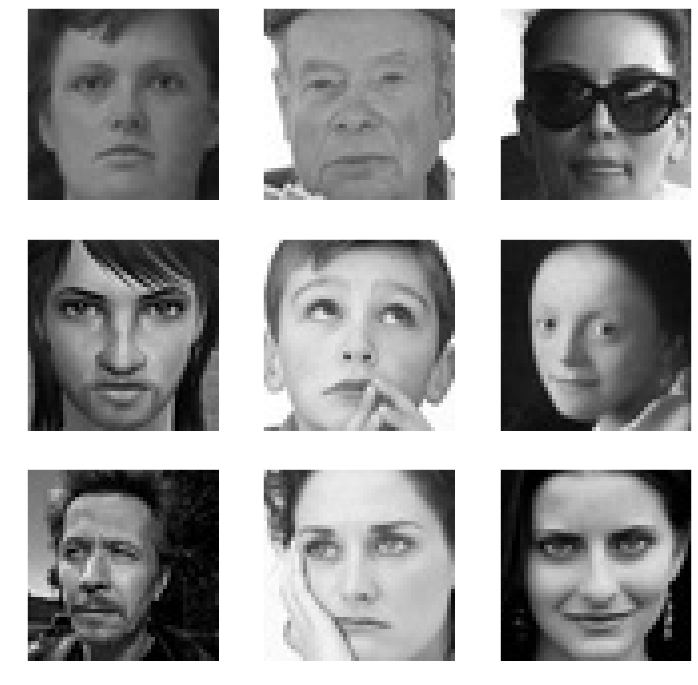

In [4]:
expression = 'neutral'

plt.figure(figsize=(12,12))
plt.style.use('dark_background')
for i in range (1, 10):
    plt.subplot(3,3,i)
    imgname = os.listdir(f'{path}train/{expression}/')[i]
    img = load_img(path=f'{path}train/{expression}/{imgname}', 
                        target_size=(picture_size, picture_size))
    plt.imshow(img)
plt.show()

In [5]:
train_datagen = ImageDataGenerator()
train_generator = train_datagen.flow_from_directory(
    f'{path}train/',
    target_size=(picture_size,picture_size),
    color_mode="grayscale",
    classes=None,
    class_mode='categorical',
    batch_size=128,
    shuffle=True)
print(train_generator.class_indices)

val_datagen = ImageDataGenerator()
val_generator = val_datagen.flow_from_directory(    
    f'{path}/validation',
    target_size=(picture_size,picture_size),
    color_mode="grayscale",
    classes=None,
    class_mode='categorical',
    batch_size=128,
    shuffle=False,
    seed=100)
print(val_generator.class_indices)

Found 28821 images belonging to 7 classes.
{'angry': 0, 'disgust': 1, 'fear': 2, 'happy': 3, 'neutral': 4, 'sad': 5, 'surprise': 6}
Found 7066 images belonging to 7 classes.
{'angry': 0, 'disgust': 1, 'fear': 2, 'happy': 3, 'neutral': 4, 'sad': 5, 'surprise': 6}


<h1>Defining The Model</h1>

In [6]:
num_classes = val_generator.num_classes

# Initialising the CNN
model = Sequential()

# 1 - Convolution
model.add(Conv2D(64,(3,3), padding='same', input_shape=(48, 48,1)))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))

# 2nd Convolution layer
model.add(Conv2D(128,(5,5), padding='same'))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))

# 3rd Convolution layer
model.add(Conv2D(512,(3,3), padding='same'))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))

# 4th Convolution layer
model.add(Conv2D(512,(3,3), padding='same'))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))

# Flattening
model.add(Flatten())

# Fully connected layer 1st layer
model.add(Dense(256))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(Dropout(0.25))

# Fully connected layer 2nd layer
model.add(Dense(512))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(Dropout(0.25))

model.add(Dense(num_classes, activation='softmax'))

opt = Adam(lr=0.001)
model.compile(optimizer=opt, loss='categorical_crossentropy', metrics=['accuracy'])

model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 48, 48, 64)        640       
_________________________________________________________________
batch_normalization (BatchNo (None, 48, 48, 64)        256       
_________________________________________________________________
activation (Activation)      (None, 48, 48, 64)        0         
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 24, 24, 64)        0         
_________________________________________________________________
dropout (Dropout)            (None, 24, 24, 64)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 24, 24, 128)       204928    
_________________________________________________________________
batch_normalization_1 (Batch (None, 24, 24, 128)       5

<h1>Fitting The Model<h1>

In [7]:
# Setup simple early stopping & model checkpoint
es = EarlyStopping(monitor='val_loss', min_delta=0, patience=10, verbose=1, restore_best_weights=True)
mc = ModelCheckpoint("./model.h5", monitor='val_accuracy', verbose=1, save_best_only=True, mode='max')
check_LR = ReduceLROnPlateau(monitor='val_loss', factor = 0.2, patience=3, verbose=1, min_delta=0.0001)
callbacks_list = [es,mc,check_LR]

In [ ]:
history = model.fit_generator(generator=train_generator, 
        steps_per_epoch= train_generator.n//train_generator.batch_size,
        validation_data=val_generator,
        validation_steps=val_generator.n//val_generator.batch_size,
        epochs=5, callbacks=callbacks_list)

Epoch 1/5
225/225 [==============================] - ETA: 0s - loss: 1.1858 - accuracy: 0.5480
Epoch 00001: val_accuracy improved from 0.43040 to 0.54759, saving model to .\model.h5
225/225 [==============================] - 1141s 5s/step - loss: 1.1858 - accuracy: 0.5480 - val_loss: 1.2107 - val_accuracy: 0.5476
Epoch 2/5
181/225 [=======================>......] - ETA: 3:10 - loss: 1.1098 - accuracy: 0.5799

NameError: name 'history' is not defined

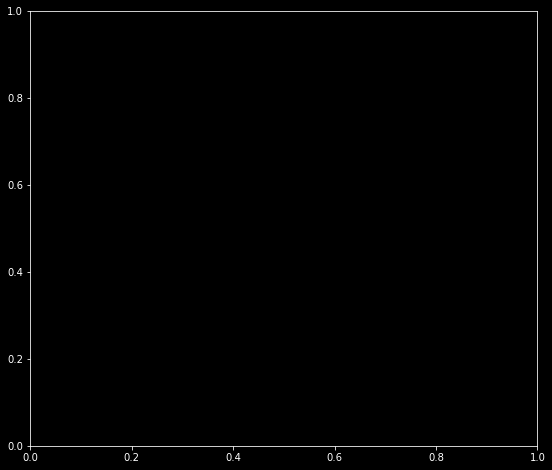

In [9]:
plt.figure(figsize=(20,8))
plt.style.use('dark_background')
plt.subplot(1,2,1)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.ylabel('Loss', fontsize=16)
plt.legend(loc='best')
plt.subplot(1,2,2)
plt.plot(history.history['accuracy'], label='Training Acc')
plt.plot(history.history['val_accuracy'], label='Validation Acc')
plt.ylabel('Accuracy', fontsize=16)
plt.legend(loc='best')
plt.show()